# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 29.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os
import string
import csv
from google.colab import drive
from sklearn.metrics import accuracy_score

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [5]:
# TODO: Load read and load the data here
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/twitter-suicidal-data.csv")
twitts = df["tweet"].to_list()
labels = df["intention"].to_list()

Mounted at /content/drive


## Data Preprocessing

In [6]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger", "words"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [7]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""

stopwords = nltk.corpus.stopwords.words("english")
english_words = set(nltk.corpus.words.words())
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'


def text_lowercase(text):
    return text.lower()

def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(text):
  return re.sub(r'\d+', '', text)

def remove_link(text):
  patterns = ['www.*\s+', 'https?.*\s+']
  for pattern in patterns:
    links = re.findall(pattern, text)
    for link in links:
      text = text.replace(link, ' ')
  return text

def remove_id(text):
  pattern = '@.*'
  ids = re.findall(pattern, text)
  for id in ids:
    text = text.replace(id, ' ')
  return text

def demojize(text):
  text = emoji.demojize(text)
  pattern = ':.*:'
  emojies = re.findall(pattern, text)
  for em in emojies:
    text = text.replace(em, " ")
  return text
def remove_whitespace(text):
    return  " ".join(text.split())

def remove_non_english_words(text):
  return " ".join(w for w in text.split(" ") if w in english_words)

def tokenize_and_lematizig(text):
  word_tokens = word_tokenize(text)
  word_tokens = nltk.pos_tag(word_tokens)
  lemma = [lemmatizer.lemmatize(w[0], pos = nltk_pos_tagger(w[1])) for w in word_tokens]
  return lemma

def remove_stop_words(word_tokens):
    word_tokens = [word for word in word_tokens if word not in stopwords]
    return word_tokens

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    text = text_lowercase(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_link(text)
    text = remove_id(text)
    text = demojize(text)
    text = remove_whitespace(text)
    text = remove_non_english_words(text)
    word_tokens = tokenize_and_lematizig(text)
    tokens = remove_stop_words(word_tokens)

    return tokens


* some times we need to know the words in the beginnings of the sentences and it may effects of accuracy but in general helps to achieve text standardization, reducing the complexity and variations in the data.
in some cases we lost abbreviations and in some languages upper cases are important like german.

* removing numbers can make confusion in text like hours dates , indices. or some numbers like 0 may change the hole context some times. but in general removing them cause simplicity of model and model focuses on text more.


In [8]:
## TODO: Show some samples before/after preprocessing
print(len(twitts))
tokens_length = []
for i in range(len(twitts) // 900):
  print("\n")
  print(twitts[i])
  tokens = preprocess_data(twitts[i])
  print(tokens)
  tokens_length.append(len(tokens))

9119


my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
['life', 'meaningless', 'want', 'end', 'life', 'badly', 'life', 'completely', 'empty', 'dont', 'want', 'create', 'meaning', 'meaning', 'pain', 'long', 'hold', 'back', 'urge', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposite', 'way', 'stop', 'feel', 'jealous', 'tragic', 'like', 'gomer', 'pile', 'swift', 'end', 'able', 'bring']


muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels 
['mutter', 'die', 'daily', 'feel', '

In [9]:
preprocess_data("i dont want to die")

['dont', 'want', 'die']

# Word2Vec - Word Embedding

In [10]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [11]:
W2V_PATH = None # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.


In [12]:
print(W2V_PATH)

None


In [13]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# Dataset

* we can replace non existance words in w2v dictionary with zero vector or with closest word vecotr.

In [14]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)
        print(self.len)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
      # vector_tensor = torch.zeros(64, 300)
      # for i in range(len(tokens)):
      #   vec = self.w2v_model[tokens[i]]
      #   vector_tensor[i] = vec
      vector_tensor = []
      sample = self.w2v_model["man"]
      for token in tokens:
        if token in w2v_model.key_to_index:
          vector_tensor.append(self.w2v_model[token])
        else:
          vector_tensor.append(np.zeros_like(sample))

      #vector_tensor = [self.w2v_model[token] for token in tokens]
      vector_tensor = torch.tensor(np.array(vector_tensor))
      return vector_tensor.T

    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
      # vector_tensor = self._get_word_vectors(tokens)
      # n = self.max_sequence_len - len(tokens)
      # if n > 0:
      #   zero_vectors = torch.zeros(n, 300)
      #   vector_tensor = torch.cat((vector_tensor, zero_vectors), 0)
      # else:
      #   vector_tensor = vector_tensor[:, :self.max_sequence_len]
      # return vector_tensor
      n = len(tokens)
      #print("before padding:", n)
      if n > self.max_sequence_len :
        tokens = tokens[:self.max_sequence_len]
      else:
        tokens = tokens + ["labour" for i in range(self.max_sequence_len - n)]
      #print("after pading: ", len(tokens))
      return tokens


    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [15]:
w2v_model["man"].shape

(300,)

# Prepare Data

## Split Data into train-valid

In [16]:
# TODO: Split dataset into train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.3, random_state=42)

## Create Datasets

In [17]:
# TODO: create twitter dataset
train_dataset = Twitter(
    X_train,
    w2v_model,
    SEQUENCE_LEN
)
valid_dataset = Twitter(
    X_test,
    w2v_model,
    SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 85


<ipython-input-14-28fcf9b59ccf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-14-28fcf9b59ccf>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


6298
Deleted 0-Len Samples: 37


<ipython-input-14-28fcf9b59ccf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


2699
Train dataset length: 6298
Valid dataset length: 2699


<ipython-input-14-28fcf9b59ccf>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


# Model and Train

## Utils

In [18]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: ['cuda', 'cpu', 'auto']):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # TODO: move model's inputs to `device`
        inputs = inputs.to(device)
        labels = labels.to(device)

        # TODO: use model's forward pass to generate outputs
        outputs = model.forward(inputs)

        # TODO: calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # TODO: calculate/update model's accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct = ( outputs.argmax(1) == labels).type(torch.float).sum().item()
        batch_acc = correct / len(loader.dataset)
        test_acc += batch_acc


        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    return test_loss, test_acc


In [19]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: ['cuda', 'cpu', 'auto'],
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, shuffle=True, batch_size = batch_size)
    valid_loader = DataLoader(valid_set, shuffle=False, batch_size = batch_size)

    print(len(train_loader))

    #print(list(train_loader)[0][0].shape)
    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for idx, (inputs, labels) in enumerate(itr, start=1):
        #for  (inputs, labels) in train_loader:
            # TODO: move model's inputs to `device`
            inputs = inputs.to(device)
            labels = labels.to(device)

            #print("input shape", inputs.shape)
            # TODO: use model's forward pass to generate outputs
            outputs = model.forward(inputs)
            #print("output shape", outputs.shape)
            # TODO: process model's predictipns and calculate/update accuracy
            # print(outputs)
            # print(labels)



            predictions = outputs.argmax(1)
            correct = ( outputs.argmax(1) == labels).type(torch.float).sum().item()
            # print(predictions)
            # print(correct)
            batch_acc = correct / len(train_loader.dataset)
            epoch_acc  += batch_acc
            #print("acc", epoch_acc)

            # TODO: calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # TODO: 1. clear optimizer's state and zero prev grads,
            optimizer.zero_grad()
            # TODO: 2. backward calculated loss
            loss.backward()
            # TODO: 3. step optimizer
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
              )

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_accs.append(epoch_acc)

        train_losses.append(epoch_loss / batch_size)

        valid_losses.append(valid_loss / batch_size)

        valid_accs.append(valid_acc)


    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [20]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [21]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    # TODO: code here, you must fill variables below
    labels = []
    predicted = []
    for inputs, label in itr:
      inputs, label = inputs.to(device), label.to(device)
      labels += (label.tolist())
      predictions = torch.argmax(model.forward(inputs), dim=1)
      predicted += (predictions.tolist())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [22]:
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import MaxPool1d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.nn import BatchNorm1d
from torch.nn import Dropout

In [23]:
class CNN(nn.Module):
  def __init__(self, numChannels, classes): # TODO: define your args here
    super(CNN, self).__init__()
    # TODO: define you network's layers here

    self.conv1 = nn.Conv1d(in_channels=numChannels, out_channels=64,kernel_size=3)
    self.relu1 = ReLU()
    # self.conv1 = Conv1d(in_channels=numChannels, out_channels=64,kernel_size=(5, 5))
    # self.relu1 = ReLU()
    # self.conv1 = Conv1d(in_channels=numChannels, out_channels=64,kernel_size=(7, 7))
    # self.relu1 = ReLU()
    self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=3)
    self.relu2 = ReLU()

    self.maxpool1 = MaxPool1d(kernel_size=2, stride=2)

    # self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=(5, 5))
    # self.relu2 = ReLU()
    # self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=(7, 7))
    # self.relu2 = ReLU()

    #f_size = 64 * (numChannels // 2) // 2


    self.fc1 = Linear(in_features= 30 * 128, out_features=128)
    self.relu3 = ReLU()

    self.fc2 = Linear(in_features=128, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
    # TODO: implement forward pass here
    x = self.conv1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.relu2(x)


    x = self.maxpool1(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)

    x = self.fc2(x)
    x = self.logSoftmax(x)
    # predictions = torch.argmax(outputs, dim=1)

    return x

## Training

*  Adam algorithm computes adaptive learning rates for each parameter using the first and second moments of the gradients.
speeding up convergence and improving the quality of the final solution.

Momentum speeds up training by accelerating gradients in the right directions by adding a fraction of the previous gradient to the current one.

In RMSProp, we look at the “steepness” of the error surface for each parameter to update the learning rate adaptively. Parameters with high gradients get smaller update steps, and low gradients allow bigger steps.

Adam tends to converge faster, while SGD often converges to more optimal solutions. SGD’s high variance disadvantages gets rectified by Adam (as advantage for Adam).

when we have a sparse data set where some features are frequently occurring and others are rare, then opting for a same learning rate for all the parameters will not be a good idea. so they make adam instead of sgd

* cross entropy:  commonly used in classification tasks , measures the difference between the discovered probability distribution of a classification model and the predicted values.It works well when the model outputs are probabilities.


In [24]:
# TODO: instantiate your model here
cnn_model = CNN(300, 2)

In [25]:
# TODO: train your model
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = LEARNING_RATE)
cnn_model_train_history = train_model(model = cnn_model,
                                      batch_size = BATCH_SIZE,
                                      loss_function = nn.CrossEntropyLoss(),
                                      optimizer = optimizer,
                                      epochs = EPOCHS,
                                      train_set = train_dataset,
                                      valid_set = valid_dataset,
                                      device = DEVICE)

99


(Training) Epoch [1/15]:  96%|█████████▌| 95/99 [00:05<00:00, 30.62it/s, accuracy=0.843, loss=0.512]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


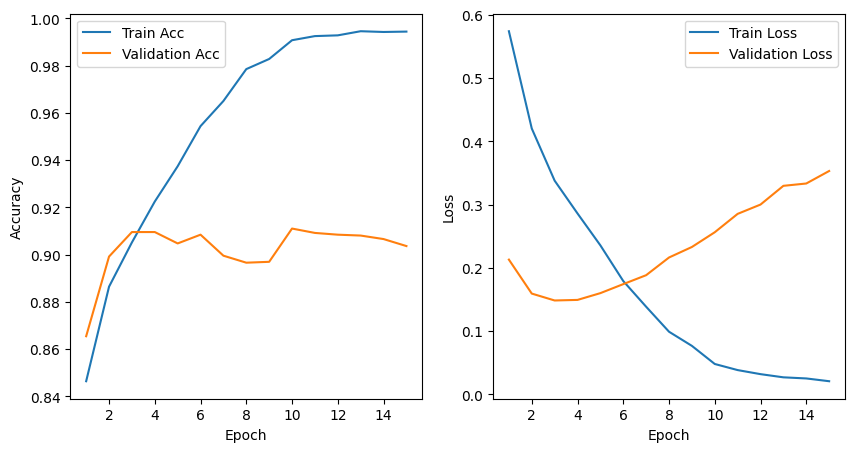

In [26]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

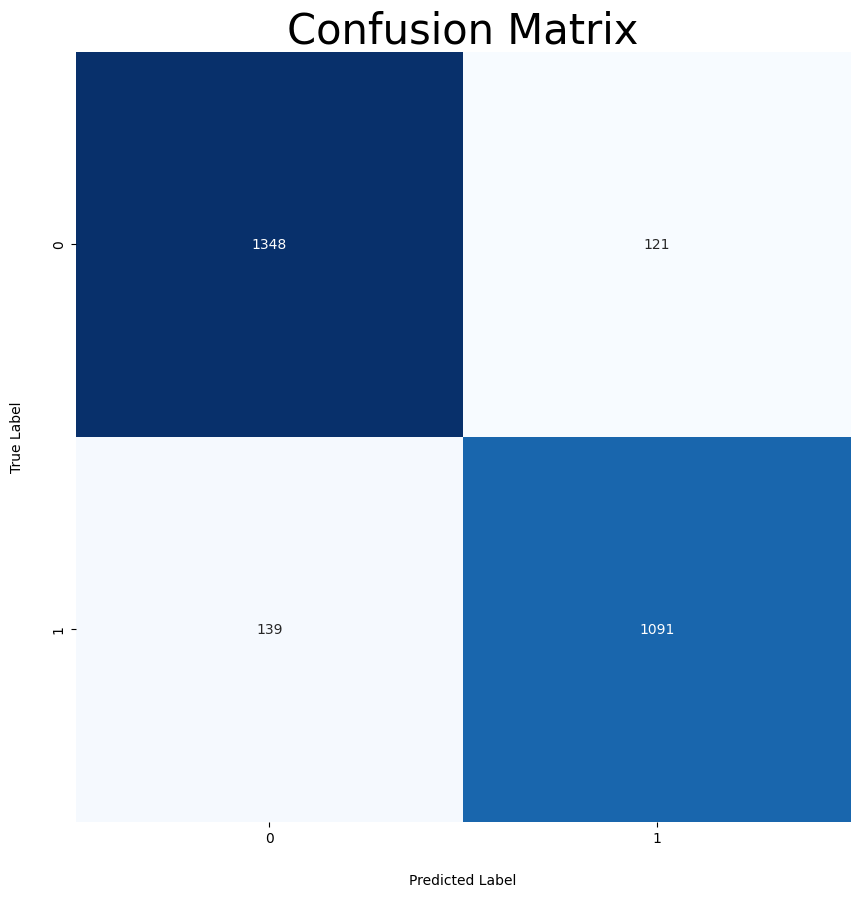

In [27]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [28]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.902
F1:        0.903
Precision: 0.903
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1469
           1       0.90      0.89      0.89      1230

    accuracy                           0.90      2699
   macro avg       0.90      0.90      0.90      2699
weighted avg       0.90      0.90      0.90      2699



* in this case with these 3 kernel sizes accuracy doesnt change much.

bigger size of kernel is better when we want to recognize object in image or some thing like that because we can check more pixels with each kernel.
when the kermel size is smaller it focus on details more. its better for classification. bigger kernels can underestand relation between pixels more.

99


99


99


99


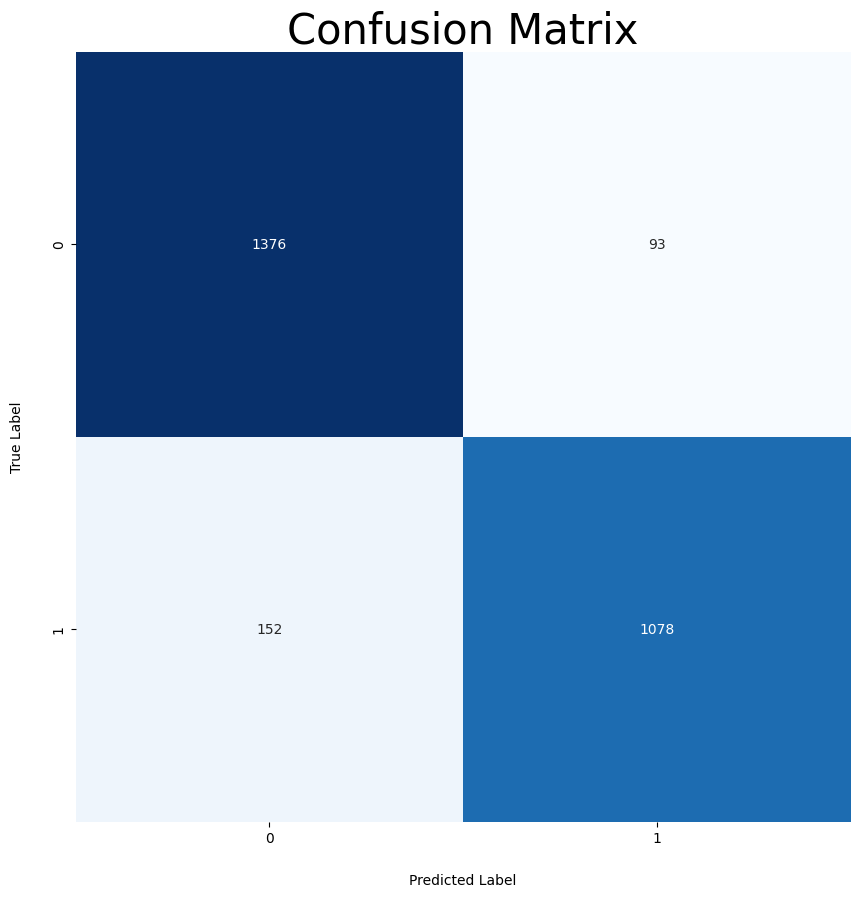

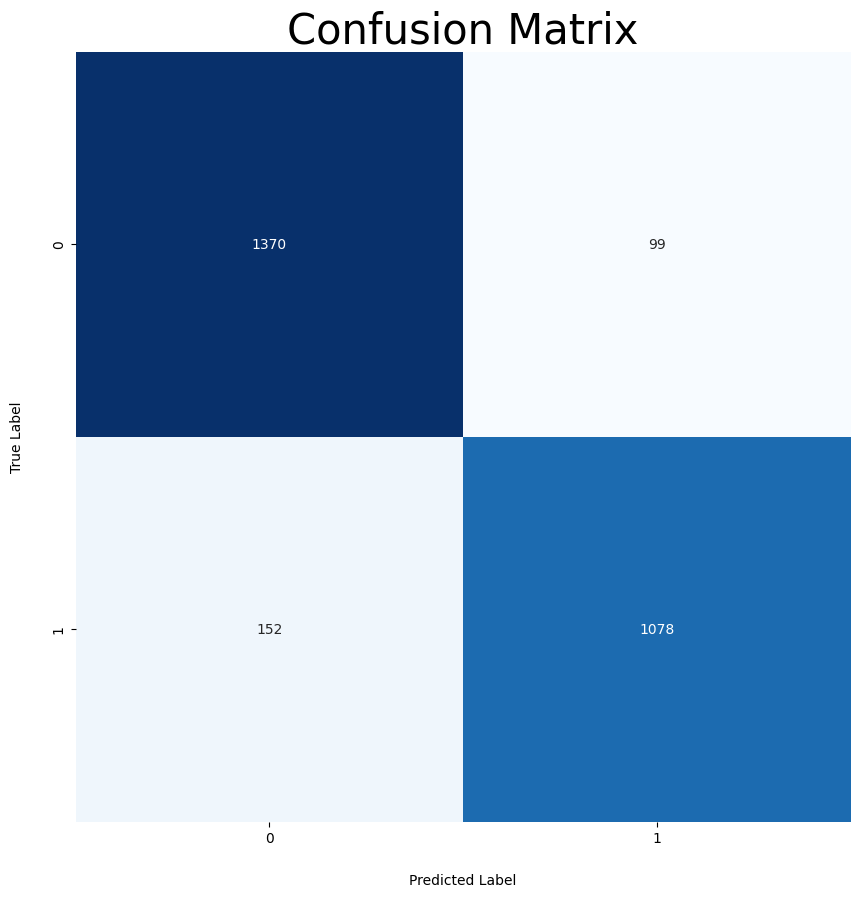

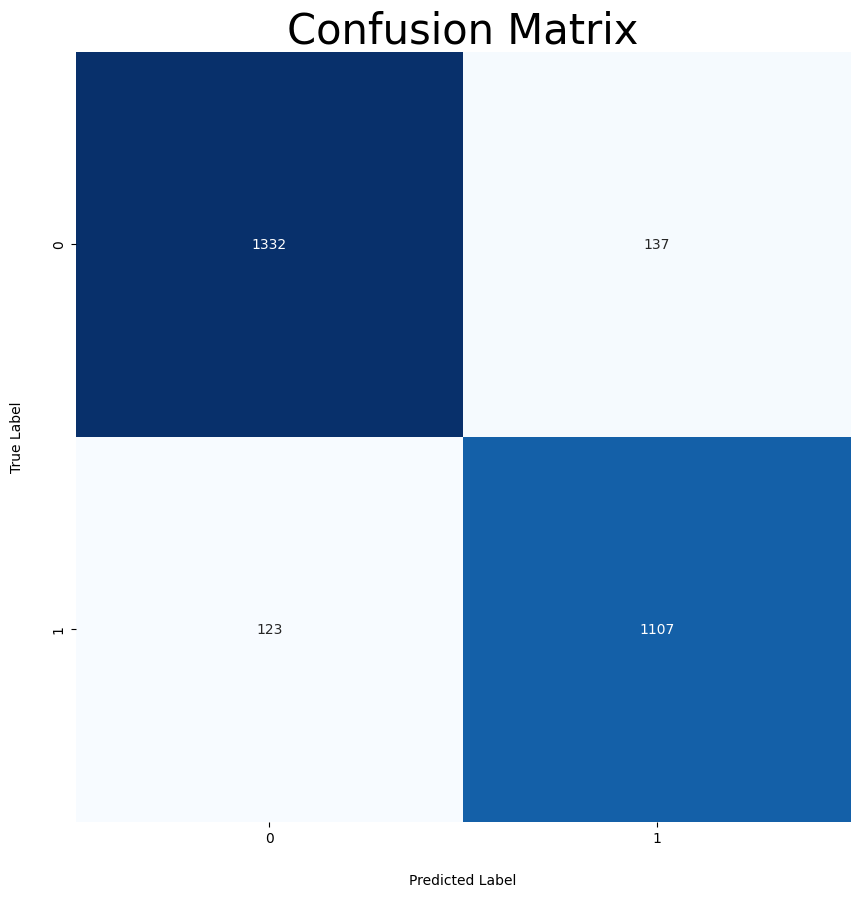

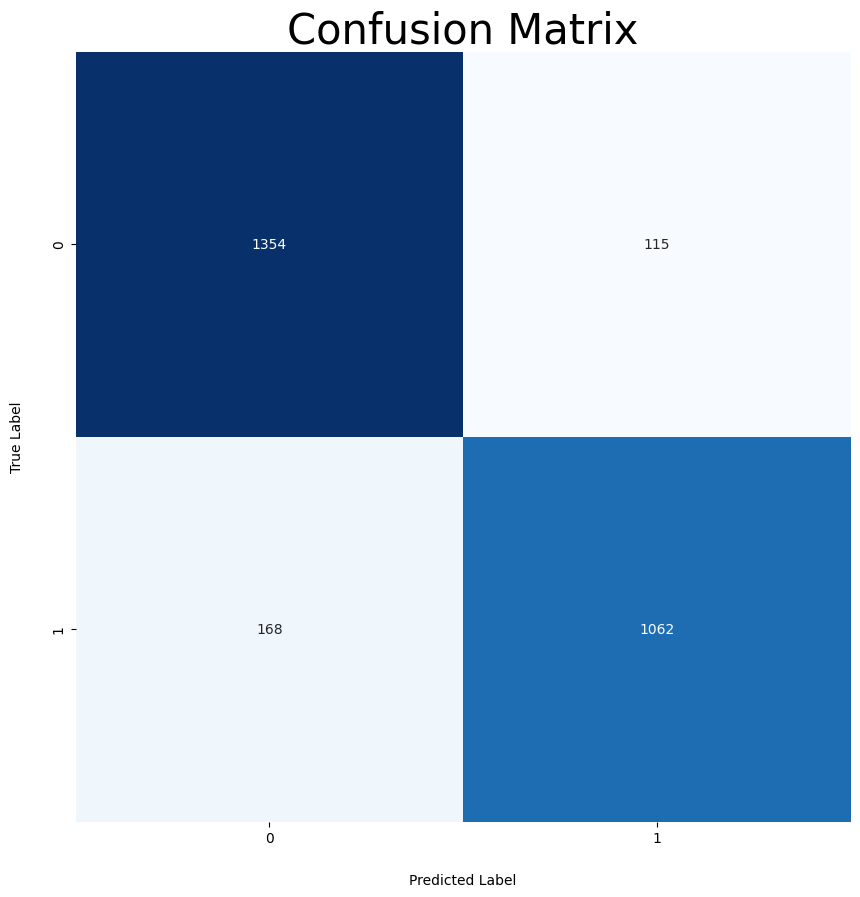

In [29]:
accuracy = []
for lr in [2e-5, 4e-4, 1e-3, 1e-2]:
  optimizer = torch.optim.Adam(cnn_model.parameters(), lr = lr)
  cnn_model_train_history = train_model(model = cnn_model,
                                      batch_size = BATCH_SIZE,
                                      loss_function = nn.CrossEntropyLoss(),
                                      optimizer = optimizer,
                                      epochs = EPOCHS,
                                      train_set = train_dataset,
                                      valid_set = valid_dataset,
                                      device = DEVICE)
  cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
  )
  accuracy.append(cnn_model_report['recall'])



Text(0, 0.5, 'recall')

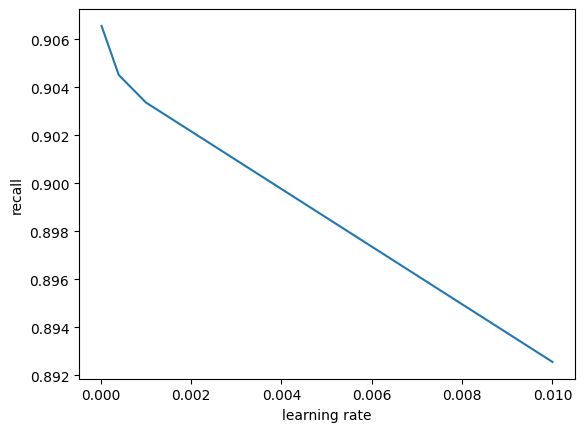

In [30]:
plt.plot([2e-5, 4e-4, 1e-3, 1e-2], accuracy)
plt.xlabel("learning rate")
plt.ylabel("recall")

In [31]:
# TODO: Split dataset into train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.3, random_state=42)

In [32]:
SEQUENCE_LEN = 196

In [33]:
# TODO: create twitter dataset
train_dataset = Twitter(
    X_train,
    w2v_model,
    SEQUENCE_LEN
)
valid_dataset = Twitter(
    X_test,
    w2v_model,
    SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 85


<ipython-input-14-28fcf9b59ccf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-14-28fcf9b59ccf>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


6298
Deleted 0-Len Samples: 37


<ipython-input-14-28fcf9b59ccf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


2699
Train dataset length: 6298
Valid dataset length: 2699


<ipython-input-14-28fcf9b59ccf>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [34]:
class CNN2(nn.Module):
  def __init__(self, numChannels, classes): # TODO: define your args here
    super(CNN2, self).__init__()
    # TODO: define you network's layers here

    self.conv1 = nn.Conv1d(in_channels=numChannels, out_channels=64,kernel_size=3)
    self.relu1 = ReLU()
    # self.conv1 = Conv1d(in_channels=numChannels, out_channels=64,kernel_size=(5, 5))
    # self.relu1 = ReLU()
    # self.conv1 = Conv1d(in_channels=numChannels, out_channels=64,kernel_size=(7, 7))
    # self.relu1 = ReLU()
    self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=3)
    self.relu2 = ReLU()

    self.maxpool1 = MaxPool1d(kernel_size=2, stride=2)

    # self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=(5, 5))
    # self.relu2 = ReLU()
    # self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=(7, 7))
    # self.relu2 = ReLU()

    #f_size = 64 * (numChannels // 2) // 2


    self.fc1 = Linear(in_features= 96 * 128, out_features=128)
    self.relu3 = ReLU()

    self.fc2 = Linear(in_features=128, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
    # TODO: implement forward pass here
    x = self.conv1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.relu2(x)

    x = self.maxpool1(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)

    x = self.fc2(x)
    x = self.logSoftmax(x)
    # predictions = torch.argmax(outputs, dim=1)

    return x

In [35]:
cnn_model = CNN2(300, 2)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr = LEARNING_RATE)
cnn_model_train_history = train_model(model = cnn_model,
                                      batch_size = BATCH_SIZE,
                                      loss_function = nn.CrossEntropyLoss(),
                                      optimizer = optimizer,
                                      epochs = EPOCHS,
                                      train_set = train_dataset,
                                      valid_set = valid_dataset,
                                      device = DEVICE)

99


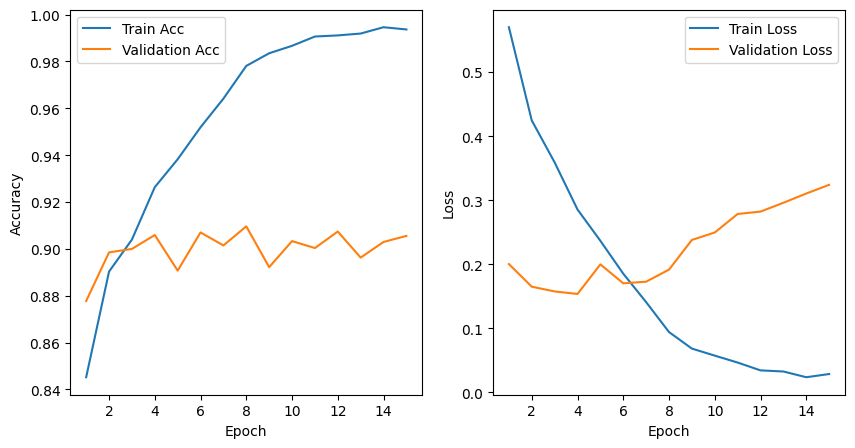

In [36]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)


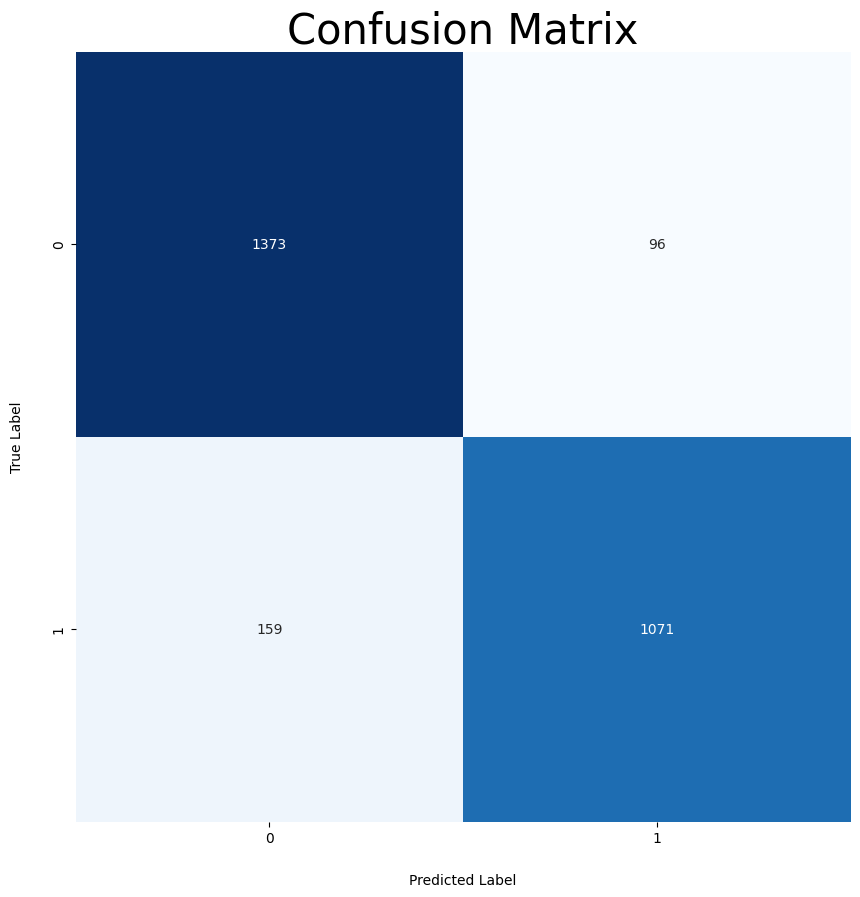

In [37]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [38]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.903
F1:        0.904
Precision: 0.907
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1469
           1       0.92      0.87      0.89      1230

    accuracy                           0.91      2699
   macro avg       0.91      0.90      0.90      2699
weighted avg       0.91      0.91      0.91      2699



In [39]:
class CNN3(nn.Module):
  def __init__(self, numChannels, classes): # TODO: define your args here
    super(CNN3, self).__init__()
    # TODO: define you network's layers here

    self.conv1 = nn.Conv1d(in_channels=numChannels, out_channels=64,kernel_size=3)
    self.relu1 = ReLU()

    self.bn1 = nn.BatchNorm1d(64)

    # self.conv1 = Conv1d(in_channels=numChannels, out_channels=64,kernel_size=(5, 5))
    # self.relu1 = ReLU()
    # self.conv1 = Conv1d(in_channels=numChannels, out_channels=64,kernel_size=(7, 7))
    # self.relu1 = ReLU()
    self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=3)
    self.relu2 = ReLU()

    self.bn2 = nn.BatchNorm1d(128)

    self.maxpool1 = MaxPool1d(kernel_size=2, stride=2)

    # self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=(5, 5))
    # self.relu2 = ReLU()
    # self.conv2 = Conv1d(in_channels=64, out_channels=128,kernel_size=(7, 7))
    # self.relu2 = ReLU()

    #f_size = 64 * (numChannels // 2) // 2


    self.fc1 = Linear(in_features= 96 * 128, out_features=128)
    self.relu3 = ReLU()

    self.dropout = Dropout(0.25)

    self.fc2 = Linear(in_features=128, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
    # TODO: implement forward pass here
    x = self.conv1(x)
    x = self.relu1(x)

    x = self.bn1(x)

    x = self.conv2(x)
    x = self.relu2(x)

    x = self.bn2(x)

    x = self.maxpool1(x)

    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)

    x = self.dropout(x)

    x = self.fc2(x)
    x = self.logSoftmax(x)
    # predictions = torch.argmax(outputs, dim=1)

    return x

In [40]:
cnn_model = CNN3(300, 2)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr = LEARNING_RATE)
cnn_model_train_history = train_model(model = cnn_model,
                                      batch_size = BATCH_SIZE,
                                      loss_function = nn.CrossEntropyLoss(),
                                      optimizer = optimizer,
                                      epochs = EPOCHS,
                                      train_set = train_dataset,
                                      valid_set = valid_dataset,
                                      device = DEVICE)

99


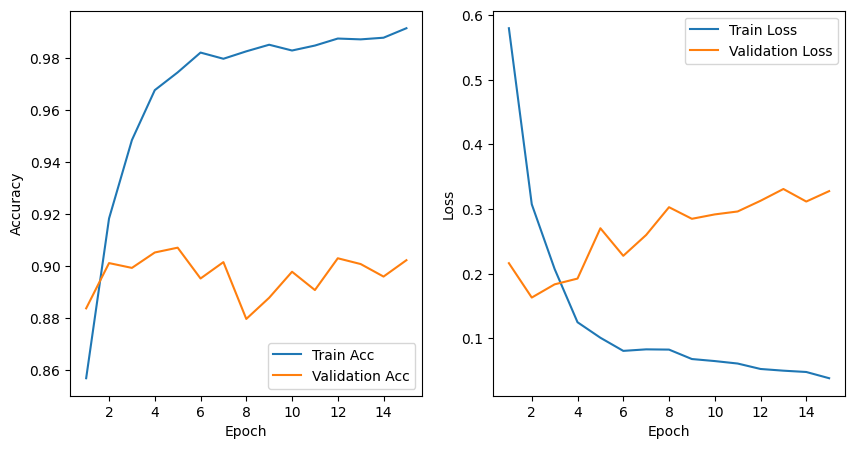

In [41]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)


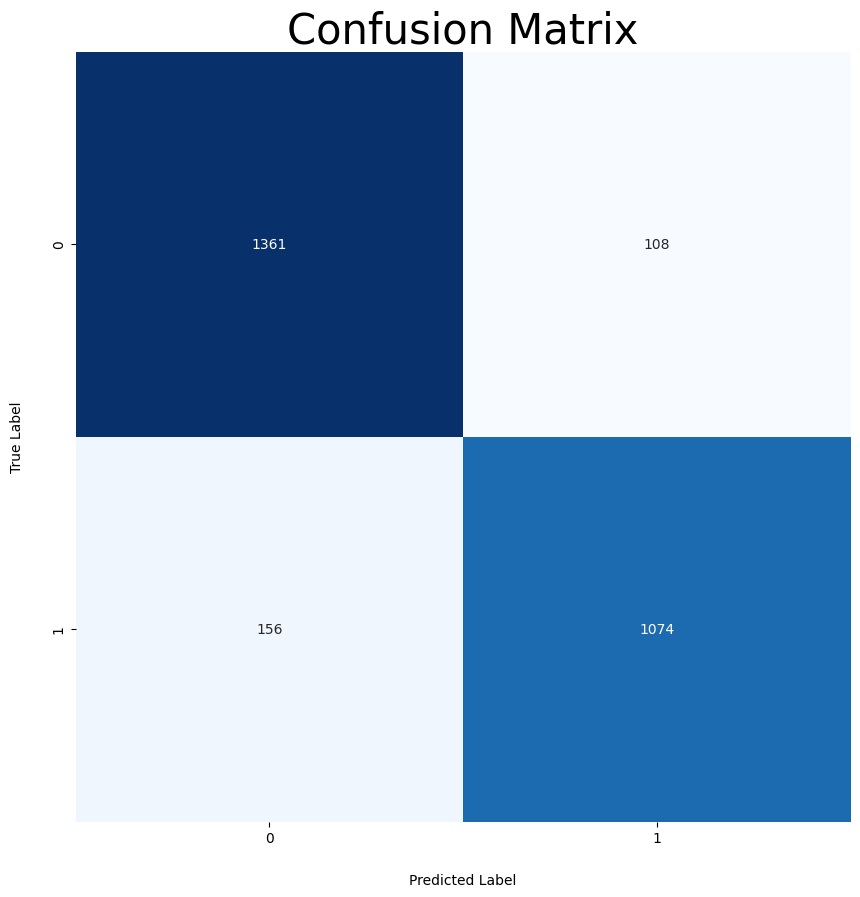

In [42]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [43]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.900
F1:        0.901
Precision: 0.903
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1469
           1       0.91      0.87      0.89      1230

    accuracy                           0.90      2699
   macro avg       0.90      0.90      0.90      2699
weighted avg       0.90      0.90      0.90      2699

